<a href="https://colab.research.google.com/github/sbooeshaghi/health-insurance/blob/main/healthcare_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import pandas as pd
import string
def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, color="lightgray",linestyle="--", zorder=0)
  ax.set_aspect('equal')
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

fsize = 20
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize

# only other place I've seen this analysis http://familycarepa.com/2018-state-health-plan/

%config InlineBackend.figure_format = 'retina'

### Insurance cost function

In [2]:
# x is cumulative amount spent
def insurance_cost(x, p, d, oopm, m=1):
  return (
      p + min(oopm, 
                 min(x*m, d) + max(0, (x*m-d)*.2)
                 )# if x > d then add (x-d)*.2 max is when x is oopm
  )

assert insurance_cost(0, 100, 100, 10_000) == 100# 1200 = p
assert insurance_cost(100, 100, 100, 10_000) == 200 # 1300 = p + d
assert insurance_cost(120_000, 100, 100, 10_000) == 10_100 # p + 10_000 = 10_100

### Tax cost function

In [3]:
income = 70_000
tax_brackets = {
          (0,  10_275): 0.10,
     (10_276,  41_775): 0.12,
     (41_776,  89_075): 0.22,
     (89_076, 170_050): 0.24,
    (170_051, 215_950): 0.32,
    (215_951, 539_900): 0.35,
    (539_901, 9999999): 0.37,
}

def tax(income, deduction):
  t = 0
  for itv, p in tax_brackets.items():
    t += max(0, (min(income - deduction, itv[1]) - itv[0]) * p)
  return t

assert tax(income, 0) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income - 41_776)*0.22
assert tax(income, 666) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-666 - 41_776)*0.22
assert tax(income, 1776) == (10_275 - 0)*0.1 + (41_775 - 10_276)*0.12 + (income-1776 - 41_776)*0.22

print(tax(15_000, 0), tax(40_000, 0))
print(tax(50_000, 0), tax(50_000, 1_000))
print(tax(50_000, 0) - tax(50_000, 1_000))
print((income - 666) - tax(income, 666), (income - 1776) - tax(income, 1776))
print((58463.86 - 57598.06))

1594.38 4594.379999999999
6616.659999999999 6396.659999999999
220.0
58463.86 57598.06
865.8000000000029


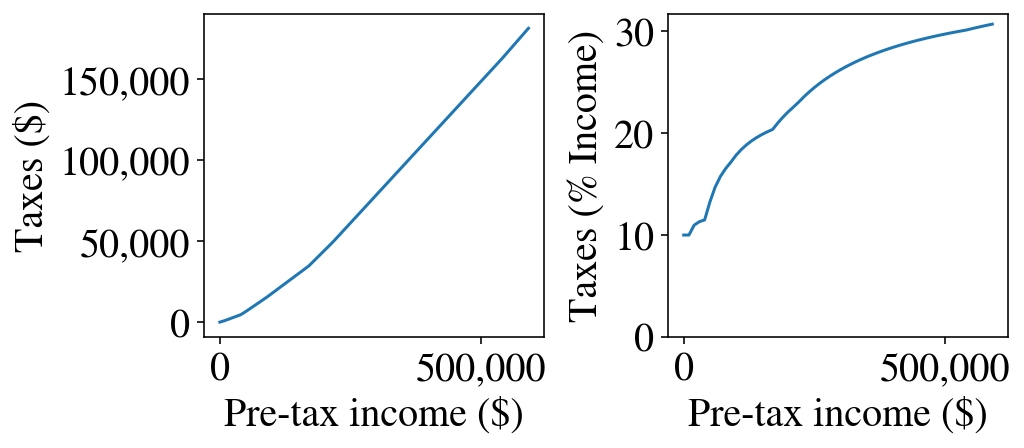

In [4]:
fig, axs = plt.subplots(figsize=(7,3), ncols=2, constrained_layout=True)

x = np.arange(1, 600_000, 10_000)

ax = axs[0]
y = np.array([tax(i, 0) for i in x])

ax.plot(x, y)#y/x*100)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes ($)"
})

ax = axs[1]
y = y/x*100

ax.plot(x, y)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**{
    "xlabel": "Pre-tax income ($)",
    "ylabel": "Taxes (% Income)",
    "ylim": 0
})

fig.show()

## Download data

In [5]:
# Download plan numbers
!curl -Ls https://raw.githubusercontent.com/sbooeshaghi/health-insurance/main/caltech-health_plans.json > caltech-health_plans.json

In [6]:
with open("caltech-health_plans.json", "r") as f:
  plans = json.load(f)

In [7]:
# Add tax deductible normalization for comparing the two PPO plans for '22 and '23
plans["PPO2800-22"]["norm"] = 0
plans["PPO1600-22"]["norm"] = tax(income, plans["PPO2800-22"]["premium"]) - tax(income, plans["PPO1600-22"]["premium"])

plans["PPO3000-23"]["norm"] = 0
plans["PPO1800-23"]["norm"] = tax(income, plans["PPO3000-23"]["premium"]) - tax(income, plans["PPO1800-23"]["premium"])

In [8]:
# This analysis will be done possible medical expenditures from $0 to $30,000
x = np.arange(0, 20_000)

# 2022 Plan comparison

156.00 1,116.00
-89.52 870.48


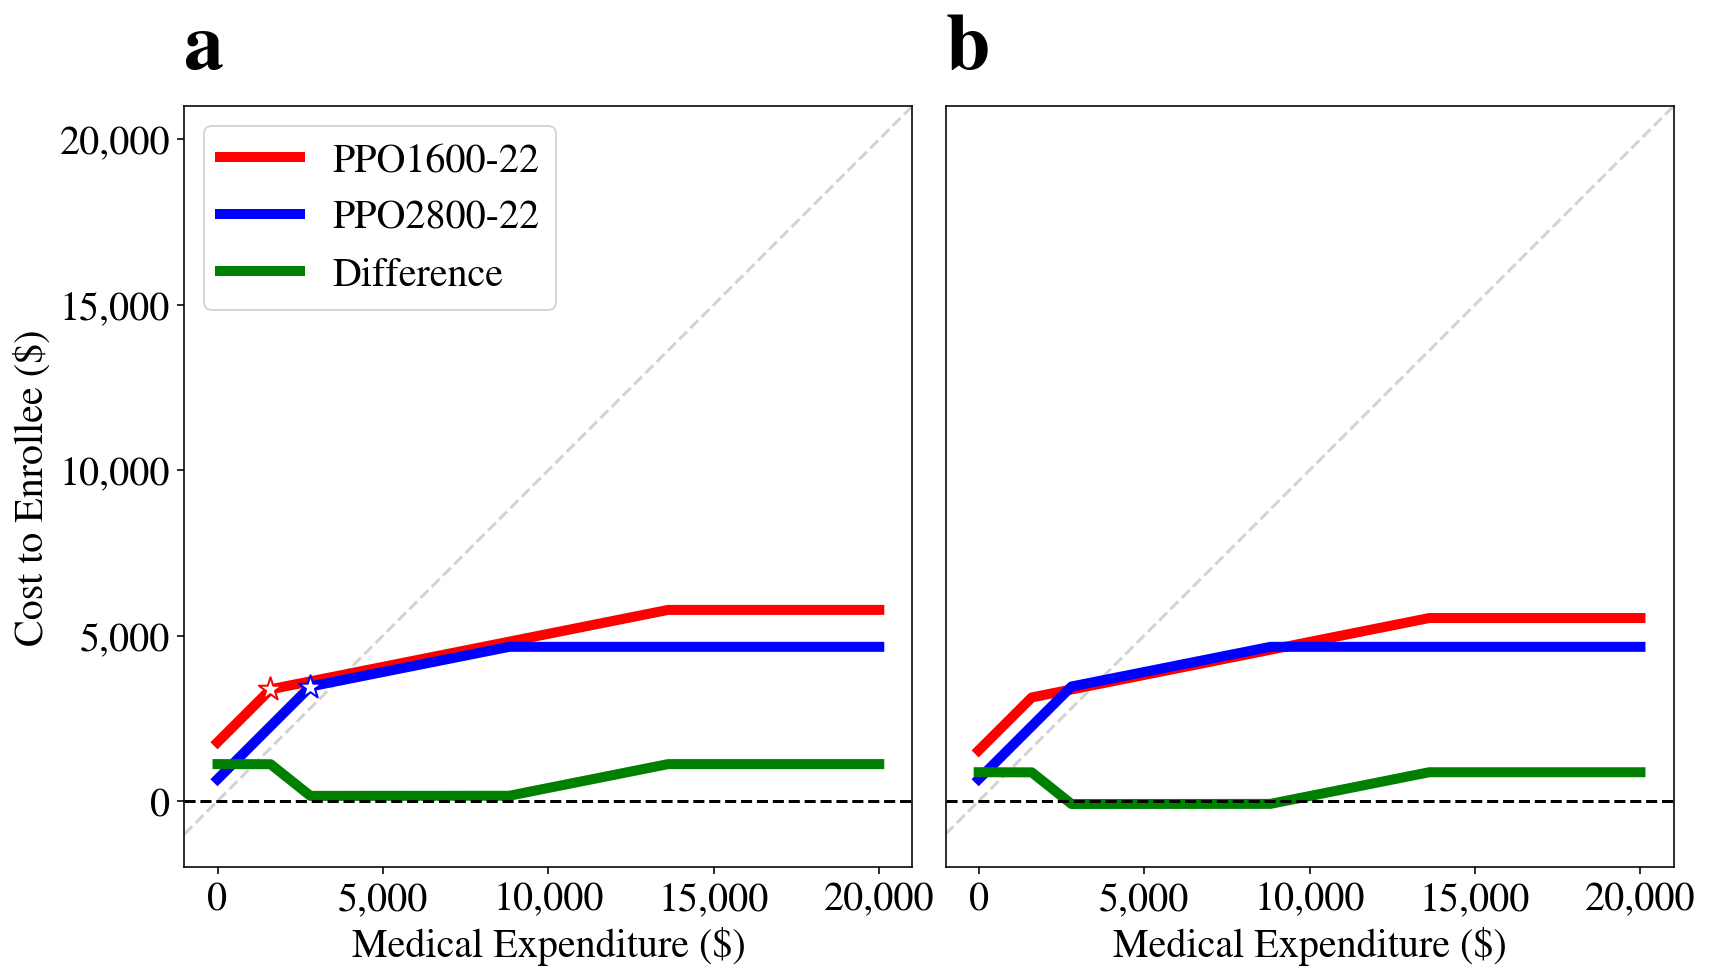

In [9]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)

##################################### First plan
plan = "PPO1600-22"
color = "red"

premium, deductible, oopm, norm = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan, color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

p1_nn = y0
p1_norm = y1

##################################### Second plan
plan = "PPO2800-22"
color = "blue"

premium, deductible, oopm, norm = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan, color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

##################################### Plot differences
p2_nn = y0
p2_norm = y1

axs[0].plot(x, p1_nn-p2_nn, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, p1_norm-p2_norm, color="green", label="Difference", linewidth=5) # Diff in price


### Plot settings
for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


##################################### plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    "ylim": -2000
})

axs[0].legend()

for n, ax in enumerate(axs.flat):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=40, weight='bold')
    
fig.savefig("plan_comparison-22.png", dpi=300, bbox_inches="tight")
fig.show()

print(f"{min(p1_nn-p2_nn):,.2f}", f"{max(p1_nn-p2_nn):,.2f}")
print(f"{min(p1_norm-p2_norm):,.2f}", f"{max(p1_norm-p2_norm):,.2f}")

In [10]:
print(x[np.where(p1_norm-p2_norm < 0)[0][0]]) # low end intersect
print(x[np.where(p1_norm-p2_norm < 0)[0][-1]]) # high end intersect

# how much are you saving in taxes with a higher premium?
print(tax(income, plans["PPO2800-22"]["premium"]) - tax(income, plans["PPO1600-22"]["premium"]))

2689
9247
245.52000000000044


In [11]:
tax(62_400, 0), tax(62_400, 1_000), (tax(62_400, 0) - tax(62_400, 1_000))

(9344.66, 9124.66, 220.0)

### 2022 Total premium cost

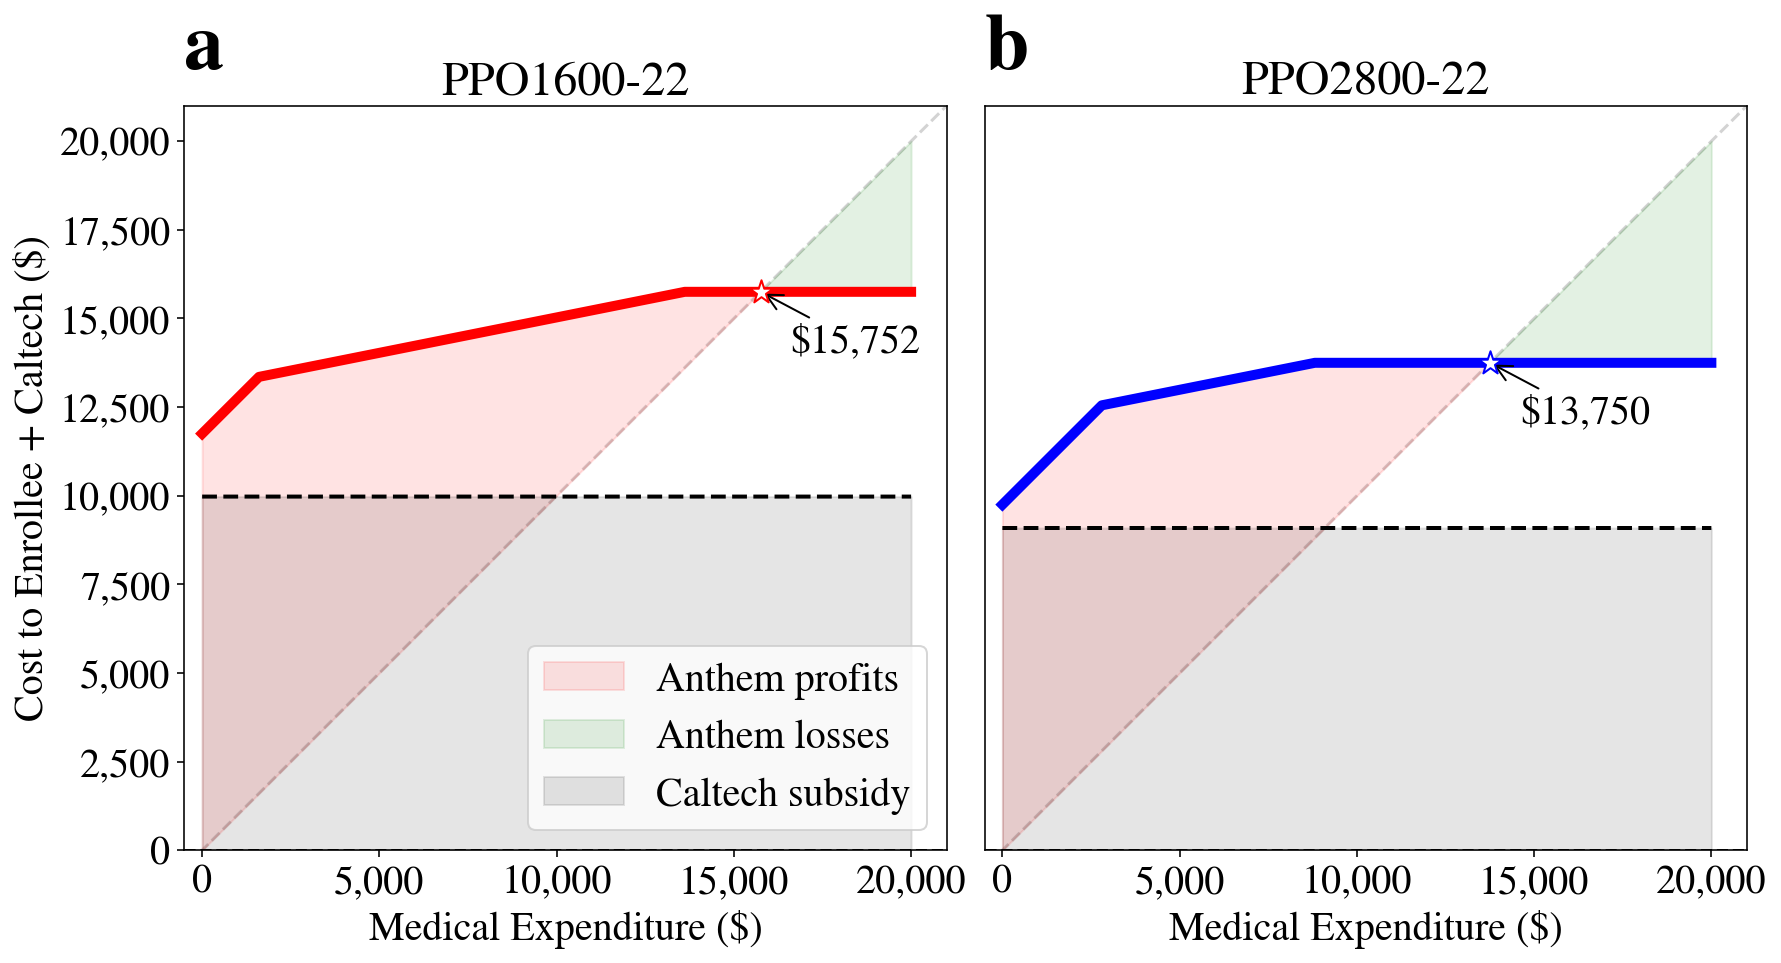

In [12]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=0.05)

## First plan
ax = axs[0]
plan="PPO1600-22"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "red"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.plot(x, len(x)*[sub], color="k", linewidth=2, linestyle="--")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Anthem losses", alpha=0.11) # Diff in price
ax.fill_between(x, len(x)*[0], len(x)*[sub], color="black", alpha=0.1, label="Caltech subsidy")

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee + Caltech ($)",
    "title": plan,
    "ylim": 0,
    "xlim": -500
})


ax.legend()

ax.text(0, 1.05, string.ascii_lowercase[0], transform=ax.transAxes, 
        size=40, weight='bold')

##### Second Plan
ax = axs[1]
plan="PPO2800-22"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "blue"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.plot(x, len(x)*[sub], color="k", linewidth=2, linestyle="--")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Anthem losses", alpha=0.11) # Diff in price
ax.fill_between(x, len(x)*[0], len(x)*[sub], color="black", alpha=0.1, label="Caltech subsidy")

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "title": plan,
    "yticklabels": [],
    "yticks": [],
    "ylim": 0,
    "xlim": -500
})

ax.text(0, 1.05, string.ascii_lowercase[1], transform=ax.transAxes, 
        size=40, weight='bold')

fig.savefig("breakeven-22.png", dpi=300, bbox_inches="tight")
fig.show()

# 2022 Income assesment

In [13]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO2800-22"]["premium"]) - tax(inc, plans["PPO1600-22"]["premium"])
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1600-22"]["premium"]-norm, plans["PPO1600-22"]["deductible"], plans["PPO1600-22"]["oopm"])
    c2 = insurance_cost(i, plans["PPO2800-22"]["premium"]     , plans["PPO2800-22"]["deductible"], plans["PPO2800-22"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

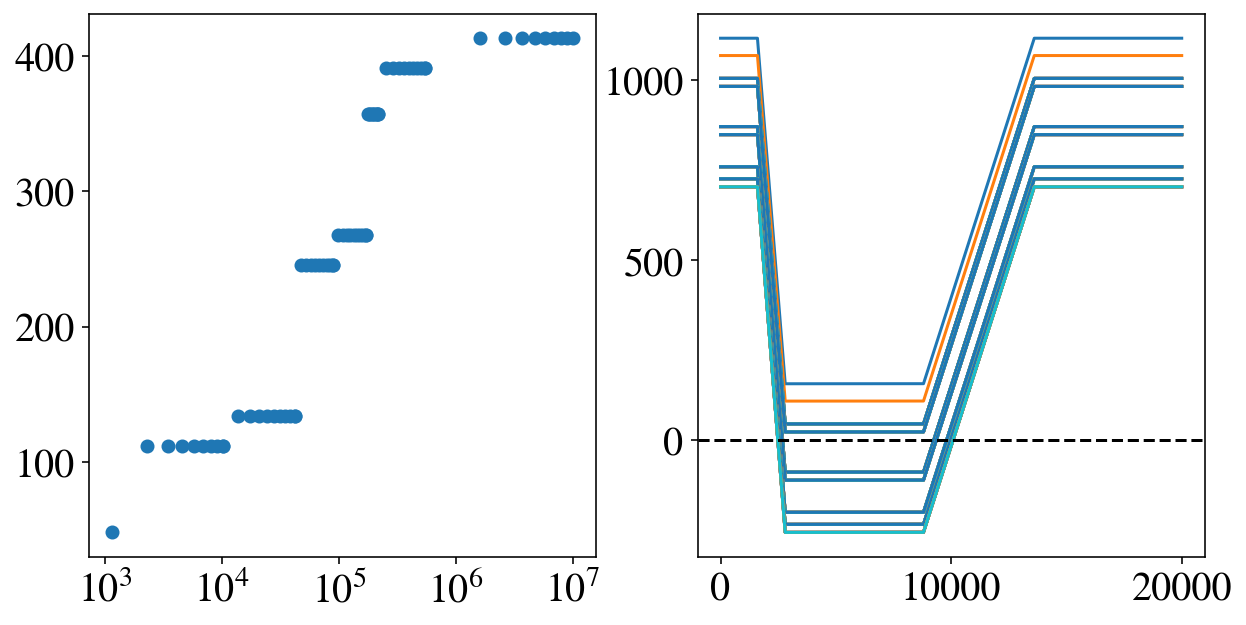

In [14]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
x = incomes[1:]
y = norms[1:]

ax.scatter(x,y)
ax.set(**{
    "xscale": "symlog"
})

ax = axs[1]
for inc, d in zip(incomes, diff):
  ax.plot(d, label=inc)

ax.axhline(0, color="k", linestyle="--")

fig.show()

In [15]:
diff.mean()

416.5879047619085

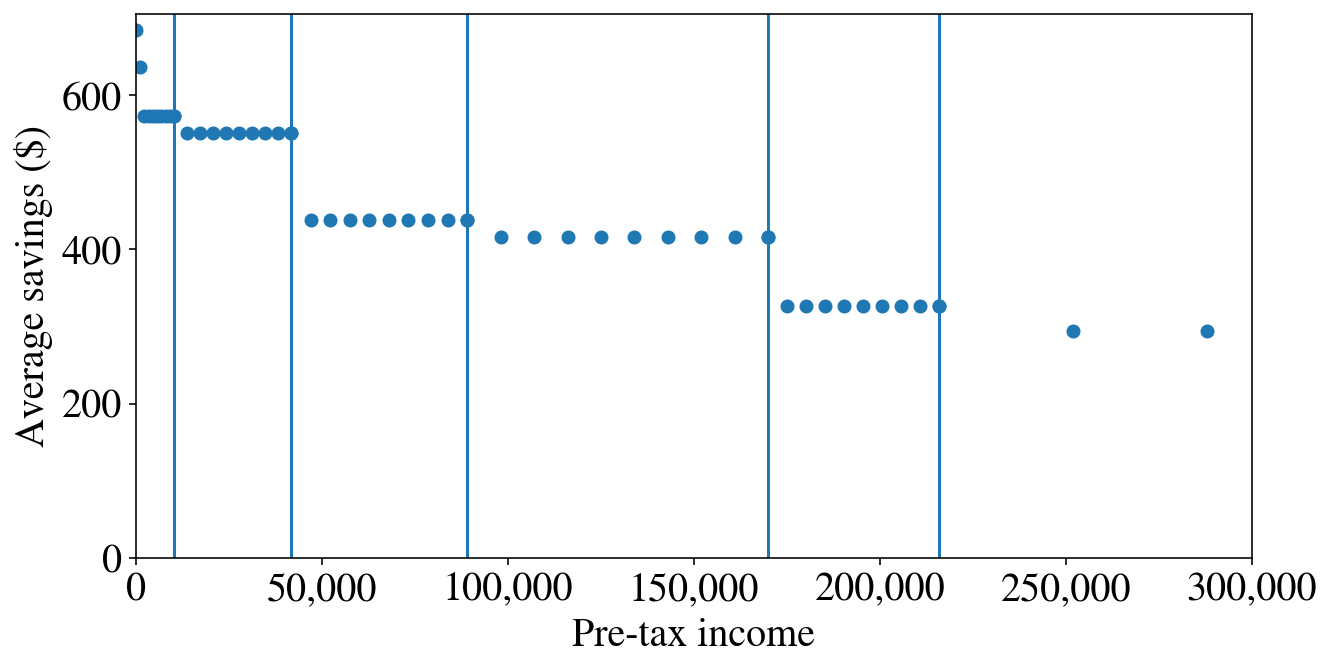

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

y = diff.mean(1)

ax.scatter(incomes,y, label="Average savings")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for l,h in tax_brackets.keys():
  ax.axvline(h)

ax.set(**{
    "xlabel": "Pre-tax income",
    "ylabel": "Average savings ($)",
    "ylim": 0,
    "xlim": (0, 300_000),
})
fig.show()

In [17]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 10275)",61.903333,1021.903333
"(10276, 41775)",24.312000,984.312000
"(41776, 89075)",-78.360000,881.640000
"(89076, 170050)",-109.608000,850.392000
"(170051, 215950)",-192.192000,767.808000
"(215951, 539900)",-231.252000,728.748000
"(539901, 9999999)",-254.688000,705.312000


# 2023 Plan comparison

In [47]:
x = np.arange(0, 20_000)

252.00 1,212.00
-14.64 945.36


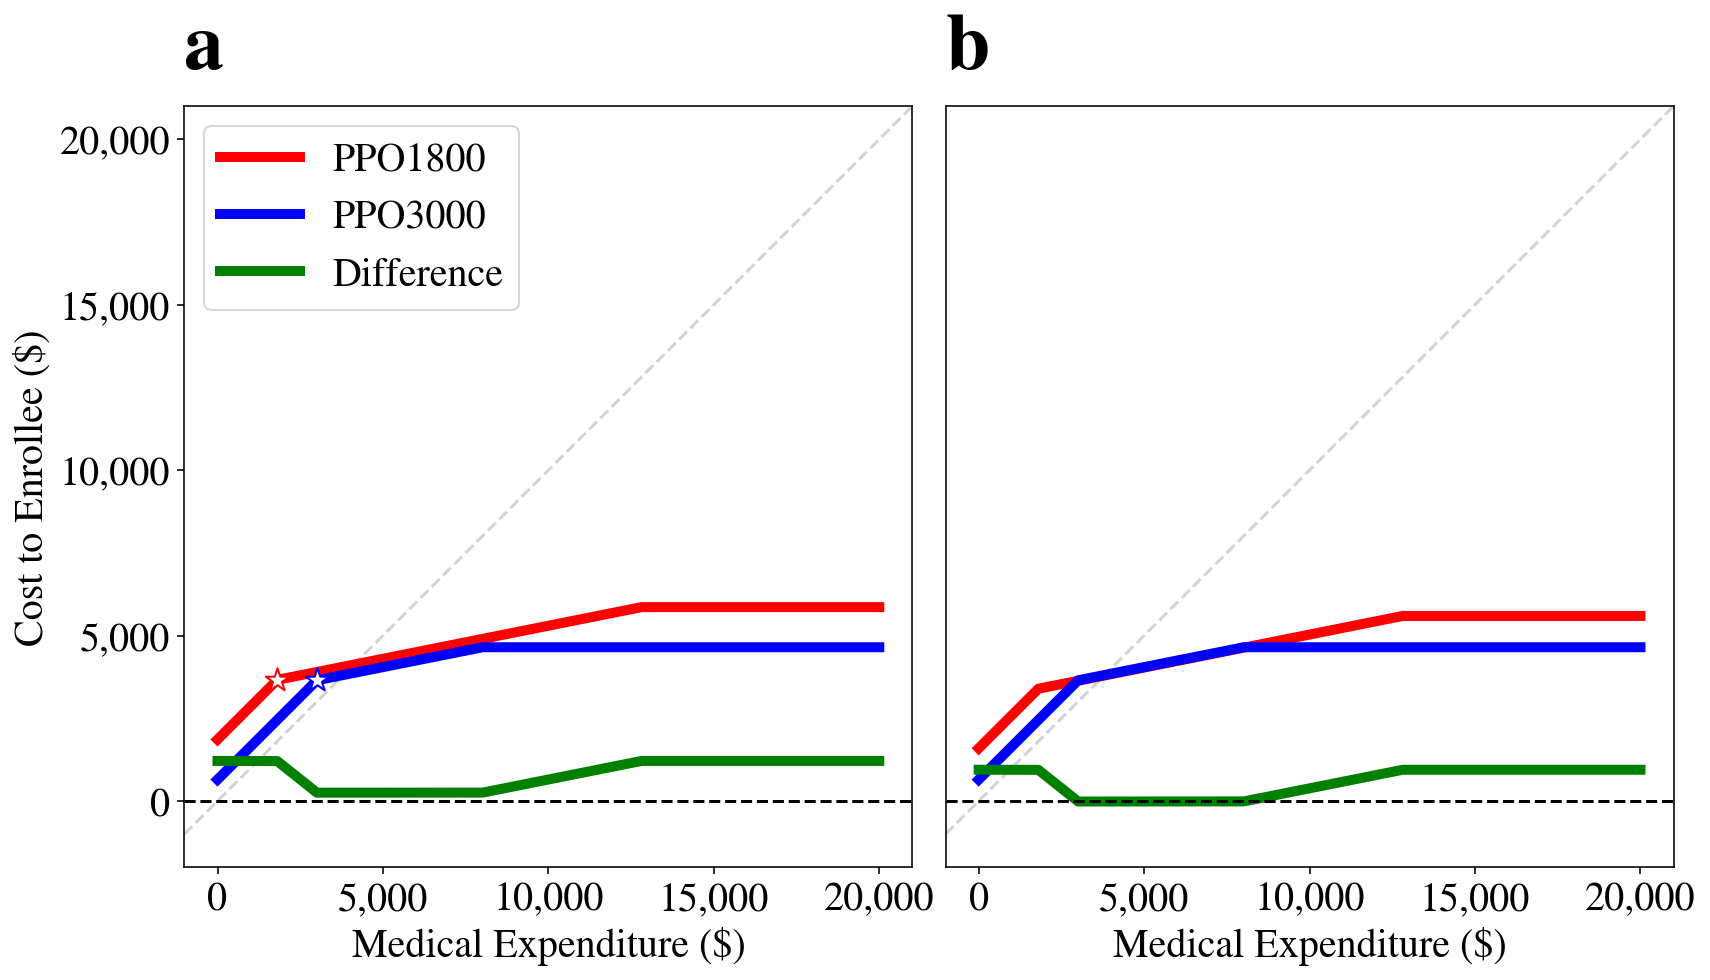

In [49]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=-0.05)

##################################### First plan
plan = "PPO1800-23"
color = "red"

premium, deductible, oopm, norm = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan.split("-")[0], color=color, linewidth=5)

p1_nn = y0
p1_norm = y1

##################################### Second plan
plan = "PPO3000-23"
color = "blue"

premium, deductible, oopm, norm = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"]
)

# Non-normalized plot
ax = axs[0]
y0 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y0, label=plan.split("-")[0], color=color, linewidth=5)
ax.scatter(deductible, deductible+premium, marker="*", edgecolor=color, s=150, zorder=10, color="white")

# Normalized plot
ax = axs[1]
y1 = np.array([insurance_cost(i, premium-norm, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)

##################################### Plot differences
p2_nn = y0
p2_norm = y1

axs[0].plot(x, p1_nn-p2_nn, color="green", label="Difference", linewidth=5) # Diff in price
axs[1].plot(x, p1_norm-p2_norm, color="green", label="Difference", linewidth=5) # Diff in price


### Plot settings
for ax in axs:
  ax.axhline(y=0, color="black", linestyle="--")
  yex(ax)
  ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


##################################### plot settings

axs[0].set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee ($)",
    "ylim": -2000
})
axs[1].set(**{
    "xlabel": "Medical Expenditure ($)",
    "yticks": [],
    "yticklabels": [],
    "ylim": -2000
})

axs[0].legend()

for n, ax in enumerate(axs.flat):

    ax.imshow(np.random.randn(10,10), interpolation='none')    
    ax.text(0, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=40, weight='bold')
    
fig.savefig("plan_comparison-23.png", dpi=300, bbox_inches="tight")
fig.show()

print(f"{min(p1_nn-p2_nn):,.2f}", f"{max(p1_nn-p2_nn):,.2f}")
print(f"{min(p1_norm-p2_norm):,.2f}", f"{max(p1_norm-p2_norm):,.2f}")

In [20]:
print(x[np.where(p1_norm-p2_norm < 0)[0][0]]) # low end intersect
print(x[np.where(p1_norm-p2_norm < 0)[0][-1]]) # high end intersect

# how much are you saving in taxes with a higher premium?
print(tax(income, plans["PPO3000-23"]["premium"]) - tax(income, plans["PPO1800-23"]["premium"]))

2982
8073
266.6399999999994


### 2023 Total premium cost

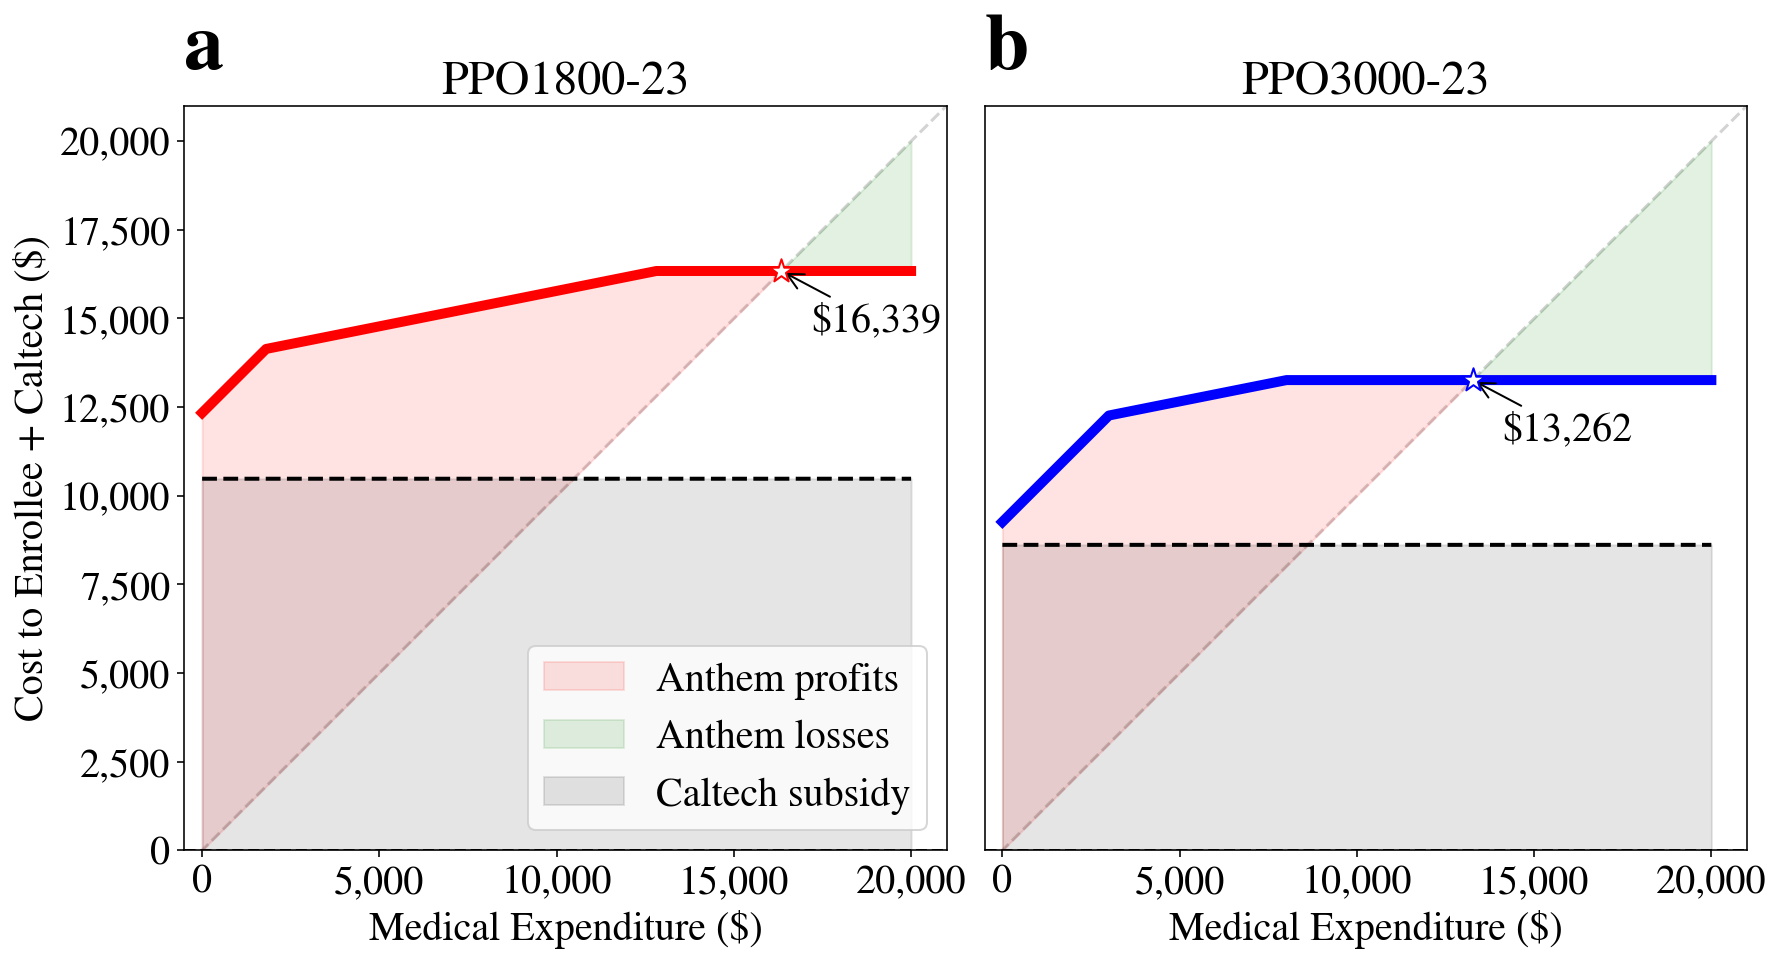

In [21]:
fig, axs = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0, wspace=0.05)

## First plan
ax = axs[0]
plan="PPO1800-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "red"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.plot(x, len(x)*[sub], color="k", linewidth=2, linestyle="--")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )
# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Anthem losses", alpha=0.11) # Diff in price
ax.fill_between(x, len(x)*[0], len(x)*[sub], color="black", alpha=0.1, label="Caltech subsidy")

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "ylabel": "Cost to Enrollee + Caltech ($)",
    "title": plan.split("-")[0],
    "ylim": 0,
    "xlim": -500
})


ax.legend()

ax.text(0, 1.05, string.ascii_lowercase[0], transform=ax.transAxes, 
        size=40, weight='bold')

##### Second Plan
ax = axs[1]
plan="PPO3000-23"
premium, deductible, oopm, norm, sub = (
    plans[plan]["premium"], 
    plans[plan]["deductible"],
    plans[plan]["oopm"], 
    plans[plan]["norm"],
    plans[plan]["premium_subsidy"]
)

premium += sub

color = "blue"

y1 = np.array([insurance_cost(i, premium, deductible, oopm) for i in x])
ax.plot(x, y1, label=plan, color=color, linewidth=5)
breakevenidx = np.where(x > y1)[0][0]
breakeven = x[breakevenidx]
ax.scatter(breakeven, breakeven, marker="*", edgecolor=color, s=150, zorder=10, color="white")
ax.plot(x, len(x)*[sub], color="k", linewidth=2, linestyle="--")
ax.annotate(f"${breakeven:,.0f}",
            xy=(breakeven, breakeven), xycoords='data',
            xytext=(15, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black')
            )

# # Difference

ax.fill_between(x[:breakevenidx], y1[:breakevenidx],x[:breakevenidx], color="red", label="Anthem profits", alpha=0.11) # Diff in price
ax.fill_between(x[breakevenidx:], y1[breakevenidx:],x[breakevenidx:], color="green", label="Anthem losses", alpha=0.11) # Diff in price
ax.fill_between(x, len(x)*[0], len(x)*[sub], color="black", alpha=0.1, label="Caltech subsidy")

ax.axhline(y=0, color="black", linestyle="--")
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


# plot settings

ax.set(**{
    "xlabel": "Medical Expenditure ($)",
    "title": plan.split("-")[0],
    "yticklabels": [],
    "yticks": [],
    "ylim": 0,
    "xlim": -500
})

ax.text(0, 1.05, string.ascii_lowercase[1], transform=ax.transAxes, 
        size=40, weight='bold')

fig.savefig("breakeven-23.png", dpi=300, bbox_inches="tight")
fig.show()

# 2023 Income assesement

In [22]:
# income ranges for different tax brackets
lst = []
for (mn, mx), v in tax_brackets.items():
  lst.append(np.linspace(mn, mx, 10).tolist())
incomes = np.array(lst).flatten()

x = np.arange(0, 20_000)


# costs for each plan in different tax brackets for each income
diff = np.zeros((incomes.shape[0], x.shape[0]))
costs = np.zeros((2, incomes.shape[0], x.shape[0]))
norms = np.zeros_like(incomes)
for idx, inc in enumerate(incomes):
  norm = tax(inc, plans["PPO3000-23"]["premium"]) - tax(inc, plans["PPO1800-23"]["premium"])
  norms[idx] = norm
  for jdx, i in enumerate(x):

    c1 = insurance_cost(i, plans["PPO1800-23"]["premium"]-norm, plans["PPO1800-23"]["deductible"], plans["PPO1800-23"]["oopm"])
    c2 = insurance_cost(i, plans["PPO3000-23"]["premium"]     , plans["PPO3000-23"]["deductible"], plans["PPO3000-23"]["oopm"])

    diff[idx][jdx]= c1-c2
    costs[0][idx][jdx] = c1
    costs[1][idx][jdx] = c2

In [23]:
# avg min savings
min_savings = (costs[0] -costs[1]).min(1).reshape(-1,10).mean(1).reshape(-1,1)

# avg max savings
max_savings = (costs[0] - costs[1]).max(1).reshape(-1,10).mean(1).reshape(-1,1)

# tax brackets
brackets = list(tax_brackets.keys())

pd.DataFrame({"min_savings":min_savings.reshape(-1), "max_savings":max_savings.reshape(-1)}, index = brackets)

,min_savings,max_savings
"(0, 10275)",150.103333,1110.103333
"(10276, 41775)",108.984000,1068.984000
"(41776, 89075)",-2.520000,957.480000
"(89076, 170050)",-36.456000,923.544000
"(170051, 215950)",-126.144000,833.856000
"(215951, 539900)",-168.564000,791.436000
"(539901, 9999999)",-194.016000,765.984000


# Year over year comparison

In [31]:
import matplotlib.gridspec as gridspec


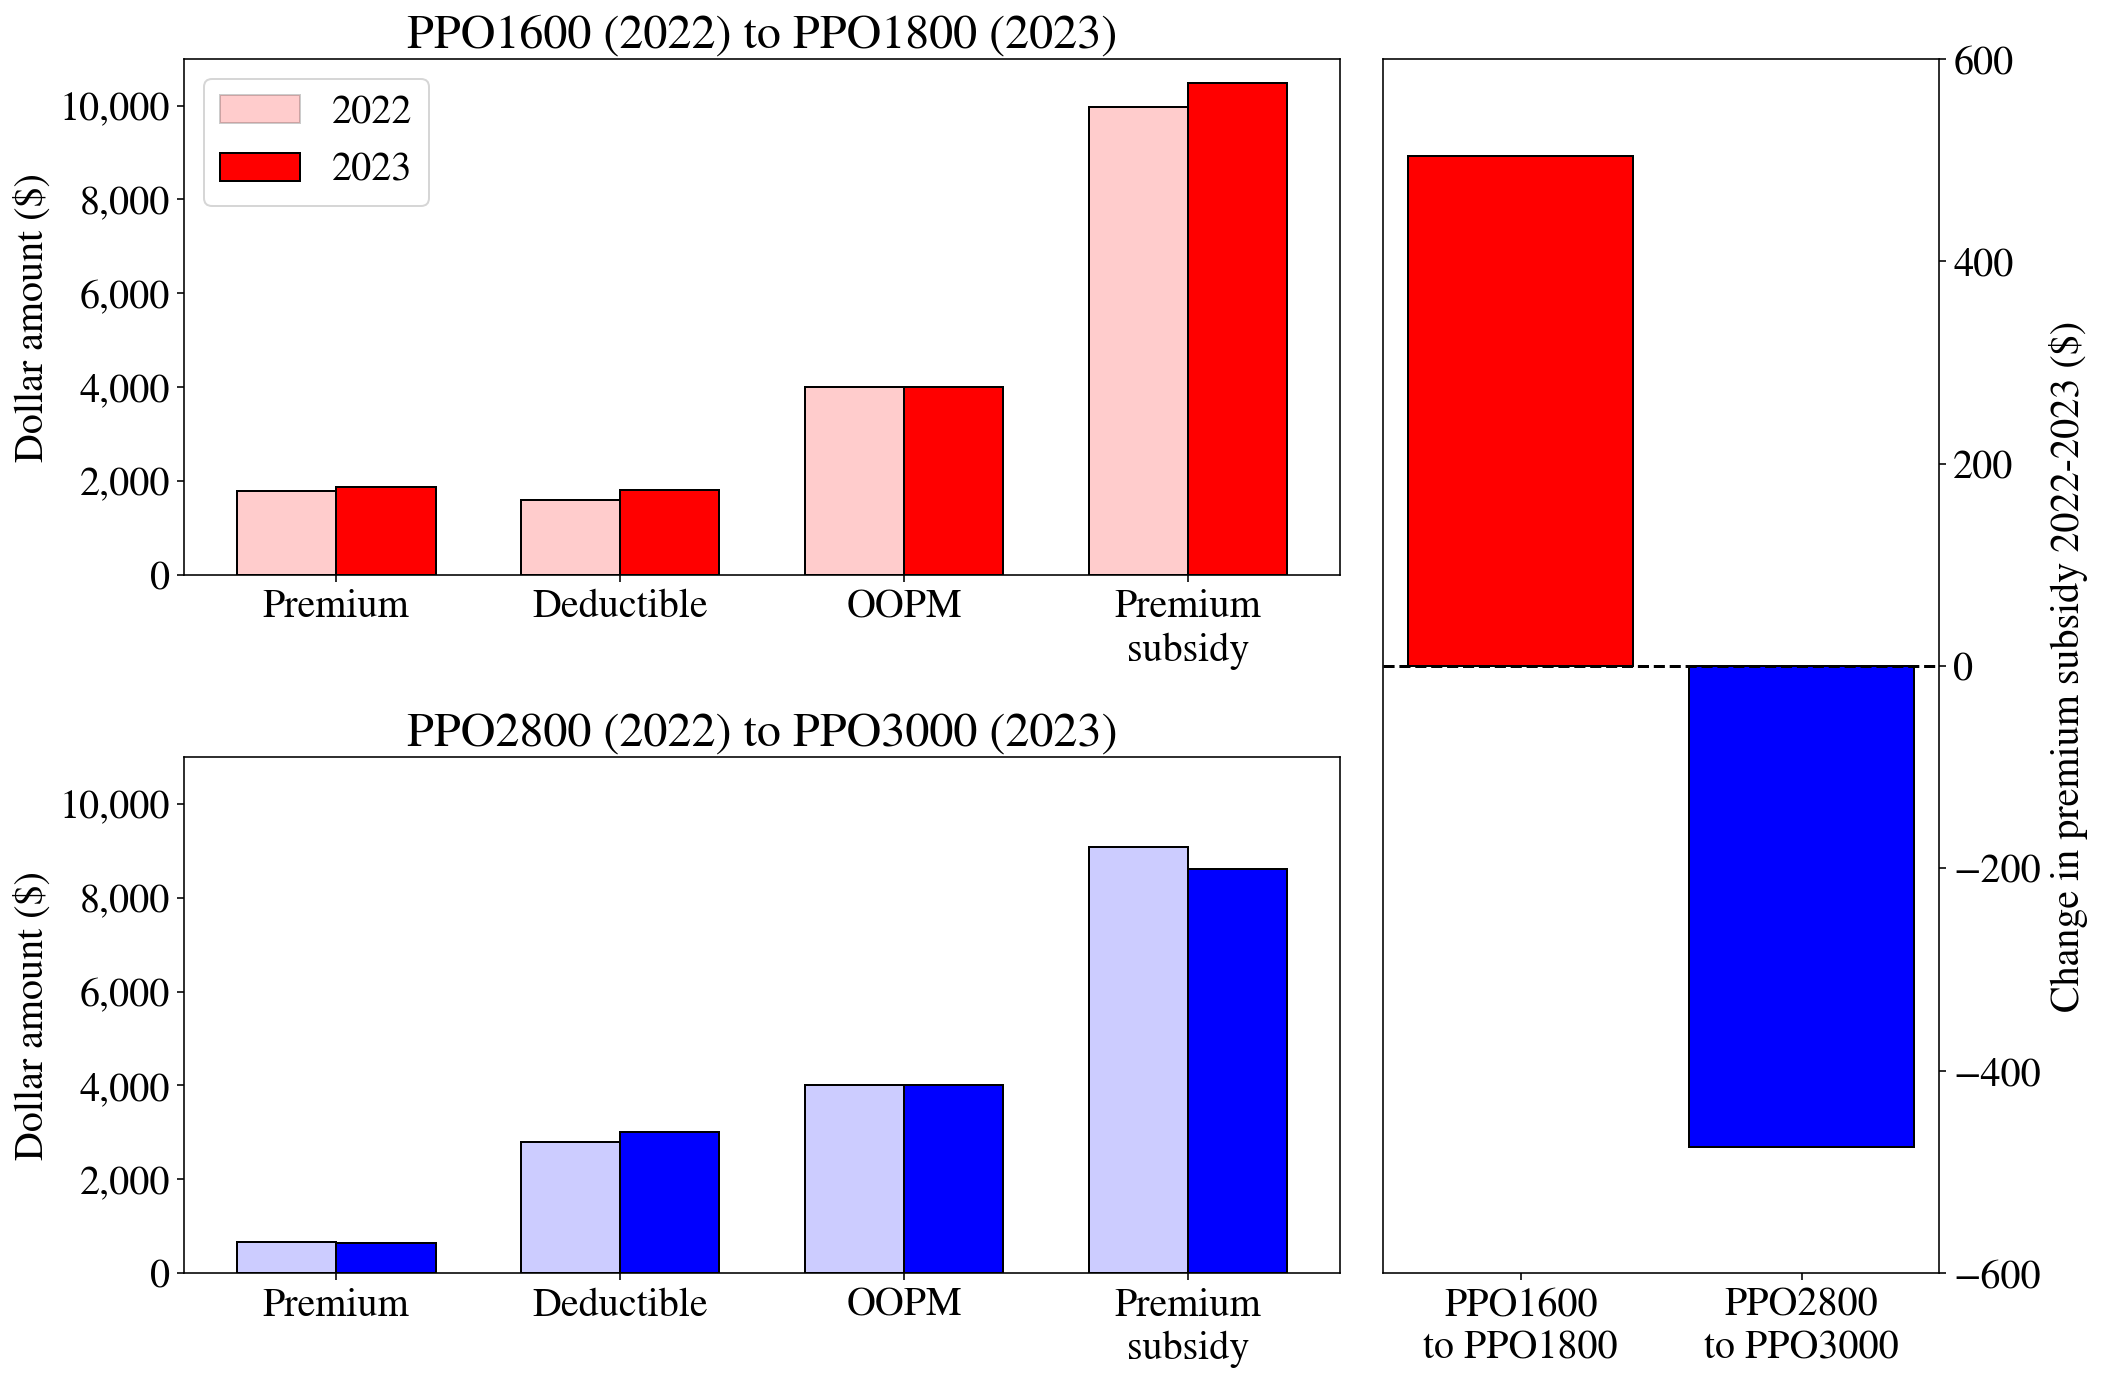

In [56]:
fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 3)

axs = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[:, 2])]

fig.subplots_adjust(hspace=0, wspace=0)

######################################################################################################################################################
ax = axs[0]
plan22 = "PPO1600-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"], 
    plans[plan22]["deductible"],
    plans[plan22]["oopm"], 
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO1800-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"], 
    plans[plan23]["deductible"],
    plans[plan23]["oopm"], 
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels)) 
width = 0.35  
ax.bar(x-width/2, y22, width=width, label=2022, edgecolor="k", color="red", alpha=0.2)
ax.bar(x-width/2, y22, width=width, edgecolor="k",  facecolor="none")
ax.bar(x+width/2, y23, width=width, label=2023, edgecolor="k", color="red")

ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "title": f"{plan22.split('-')[0]} (2022) to {plan23.split('-')[0]} (2023)",
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)"
    }
)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

##################################################################################
ax = axs[1]

plan22 = "PPO2800-22"
premium22, deductible22, oopm22, sub22 = (
    plans[plan22]["premium"], 
    plans[plan22]["deductible"],
    plans[plan22]["oopm"], 
    plans[plan22]["premium_subsidy"]
)

y22 = [
    premium22, deductible22, oopm22, sub22
]

plan23 = "PPO3000-23"
premium23, deductible23, oopm23, sub23 = (
    plans[plan23]["premium"], 
    plans[plan23]["deductible"],
    plans[plan23]["oopm"], 
    plans[plan23]["premium_subsidy"]
)
y23 = [
    premium23, deductible23, oopm23, sub23
]

labels = ["Premium", "Deductible", "OOPM", "Premium\nsubsidy"]
x = np.arange(len(labels)) 
width = 0.35  
ax.bar(x-width/2, y22, width=width, edgecolor="k",  color="blue", alpha=0.2)
ax.bar(x-width/2, y22, width=width, edgecolor="k",  facecolor="none")
ax.bar(x+width/2, y23, width=width, edgecolor="k",  color="blue")

ax.set(**{
    "xticks": x,
    "xticklabels": labels,
    "ylim": (0, 11_000),
    "ylabel": "Dollar amount ($)",
    "title": f"{plan22.split('-')[0]} (2022) to {plan23.split('-')[0]} (2023)"
    }
)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


ax = axs[2]
labels = ["PPO1600\nto PPO1800", "PPO2800\nto PPO3000"]
y = [
    plans["PPO1800-23"]["premium_subsidy"] - plans["PPO1600-22"]["premium_subsidy"],
    plans["PPO3000-23"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"], 
]
ax.bar(labels, y, edgecolor="k", color=["red", "blue"])
ax.axhline(0, color="k", linestyle="--")
ax.set(**{
    "ylabel": "Change in premium subsidy 2022-2023 ($)",
    "ylim": (-600, 600)
})
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.show()

In [25]:
print("PPO2800 -> PPO3000 subsidy change (22->23)", plans["PPO3000-23"]["premium_subsidy"] - plans["PPO2800-22"]["premium_subsidy"])
print("PPO1600 -> PPO1800 subsidy change (22->23)", plans["PPO1800-23"]["premium_subsidy"] - plans["PPO1600-22"]["premium_subsidy"])

PPO2800 -> PPO3000 subsidy change (22->23) -475.4400000000005
PPO1600 -> PPO1800 subsidy change (22->23) 503.5199999999986
